In [1]:
!pip install -q torchinfo

In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#reading files
import os
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

#plots
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

#model
import torch
from torch import nn, optim
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [4]:
seed = 322
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [5]:
def read_annot(file_name, xml_dir):
  bbox = []
  labels = []

  annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
  tree = ET.parse(annot_path)
  root = tree.getroot()

  for boxes in root.iter('object'):
    ymin = int(boxes.find("bndbox/ymin").text)-1
    xmin = int(boxes.find("bndbox/xmin").text)-1
    ymax = int(boxes.find("bndbox/ymax").text)-1
    xmax = int(boxes.find("bndbox/xmax").text)-1
    label = boxes.find('name').text

    bbox.append([xmin,ymin,xmax,ymax])
    if label == 'with_mask':
      label_idx = 2
    else:
      label_idx = 1
    labels.append(label_idx)

  return bbox, labels

In [6]:
def draw_boxes(img, boxes, labels, thickness=1):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  for box,label in zip(boxes,labels):
    box = [int(x) for x in box]
    if label == 2:
      color = (0,225,0) # green
    elif label == 1:
      color = (0,0,225) # red
    cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
dir_path = '/kaggle/input/face-mask-detection/images'
xml_path = '/kaggle/input/face-mask-detection/annotations'

file_list = os.listdir(dir_path)

print('Total {} images.'.format(len(file_list)))

Total 853 images.


(-0.5, 399.5, 299.5, -0.5)

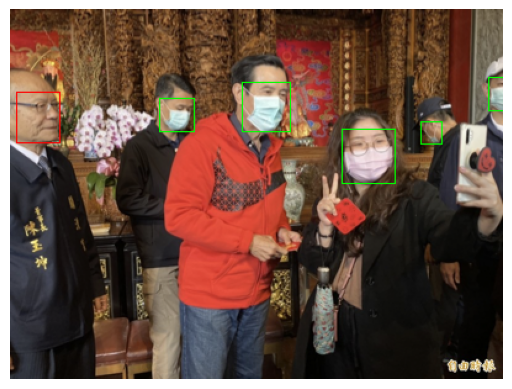

In [8]:
image_name = "maksssksksss457.png"
bbox, labels  = read_annot(image_name, xml_path)

img = draw_boxes(plt.imread(os.path.join(dir_path, image_name)), bbox, labels)
plt.imshow(img)
plt.axis('off')

In [9]:
class MaskDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform=transform

    self.image_dir = os.path.join(self.root_dir, "images")
    self.xml_dir = os.path.join(self.root_dir, "annotations")
    self.image_list = os.listdir(self.image_dir)

  def __getitem__(self, idx):
    image_name = self.image_list[idx]
    image_path = os.path.join(self.image_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes, labels = read_annot(image_name, self.xml_dir)

    if self.transform:
      augs = self.transform(image=image, bboxes=bboxes, labels=labels)

      image = augs['image']
      bboxes = torch.tensor(augs['bboxes'])
      labels = torch.tensor(augs['labels'], dtype=torch.int64)

    target = {}
    target['labels'] = labels
    target['boxes'] = bboxes

    return image, target

  def __len__(self):
    return len(self.image_list)

In [10]:
bbox_params = A.BboxParams(
  format='pascal_voc',
  min_area=5,
  min_visibility=0.9,
  check_each_transform =True,
  label_fields=['labels']
)

train_transform=A.Compose(
  [
    A.Resize(height=448, width=448),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ToTensorV2()
  ],
  bbox_params=bbox_params,
  is_check_shapes=False
)

test_transform=A.Compose(
  [
    A.Resize(height=448, width=448),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ToTensorV2(),
  ],
  bbox_params=bbox_params,
  is_check_shapes=False
)

def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
mask_dataset = MaskDataset("/kaggle/input/face-mask-detection", train_transform)

mask_loader = DataLoader(mask_dataset,
                              batch_size=1,
                              shuffle=True,
                              num_workers=0,
                              collate_fn=collate_fn)

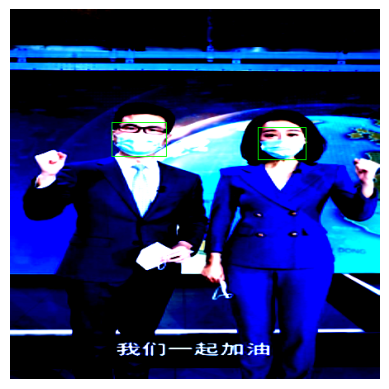

In [12]:
for image, target in mask_loader:
  img = np.transpose(image[0].numpy(), (1, 2, 0))
  new_img = draw_boxes(img, target[0]['boxes'], target[0]['labels'])

  plt.imshow(new_img)
  plt.axis('off')

  break

In [13]:
def get_dataset(
    root, train=0.8, val=0.1,
    train_transforms=None, test_transforms=None,
    random_seed=827
):
  origin = MaskDataset(
    root,
    transform=train_transforms
  )

  train_samples = int(len(origin) * train)
  val_samples = int(len(origin) * val)
  test_samples = len(origin) - train_samples - val_samples

  torch.manual_seed(random_seed)
  trainset, valset, testset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples, test_samples),
  )
  valset.transforms = test_transforms
  testset.transforms = test_transforms

  return trainset, valset, testset

trainset, valset, testset = get_dataset('/kaggle/input/face-mask-detection')
print(len(trainset), len(valset), len(testset))

682 85 86


In [14]:
def load_model(num_classes=3):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [15]:
model = load_model()
summary(model, (1, 3, 448, 448))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [16]:
def train(model, dataloader, optimizer, epoch, device):
  model.train()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (data, target) in enumerate(pbar):
      data = list(image.to(device) for image in data)
      target = [{k: v.to(device) for k, v in t.items()} for t in target]

      loss_dict = model(data, target)
      losses = sum(loss for loss in loss_dict.values())

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      running_loss += losses
      pbar.set_postfix(loss=losses.item())

    print(
        f"[{epoch}/{EPOCH}]",
        f"train loss: {running_loss/len(dataloader):.4f}"
    )

  return running_loss/len(dataloader)

In [17]:
def validation(model, dataloader, epoch, device,
               threshold_score=0.5, threshold_iou=0.5):
  model.eval()

  tps = []
  fps = []
  fns = []

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (data, target) in enumerate(pbar):
        data = list(image.to(device) for image in data)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        predictions = model(data)

      for i in range(len(target)):
        true_boxes = target[i]['boxes'].cpu()
        true_labels = target[i]['labels'].cpu().numpy()
        pred_boxes = predictions[i]['boxes'].cpu()
        pred_scores = predictions[i]['scores'].cpu().numpy()

        pred_boxes_thr = pred_boxes[pred_scores >= threshold_score]

        iou_for_img = torchvision.ops.box_iou(pred_boxes_thr, true_boxes)

        true_positives = (iou_for_img > threshold_iou).sum()
        false_positives = len(pred_boxes) - true_positives
        false_negatives = len(true_boxes) - true_positives

        tps.append(true_positives)
        fps.append(false_positives)
        fns.append(false_negatives)

  precision = sum(tps) / (sum(tps) + sum(fps))
  recall = sum(tps) / (sum(tps) + sum(fns))
  f1 = 2 * (precision * recall) / (precision + recall)

  print(f'[{epoch}/{EPOCH}] precision: {precision:.2f} recall: {recall:.2f} f1: {f1:.2f} \n')

  return precision, recall, f1

In [18]:
EPOCH = 10
BATCH_SIZE = 16
NUM_WORKERS = 2
LR = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY=0.0005
LR_SETP=6
LR_GAMMA=0.7

trainset, valset, testset = get_dataset(
  "/kaggle/input/face-mask-detection",
  train_transforms=train_transform,
  test_transforms=test_transform
)

# dataloader
train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  collate_fn=collate_fn
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  collate_fn=collate_fn
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  collate_fn=collate_fn
)

# Model
model = load_model()

# Optimizer, Loss, Scheduler
optimizer = optim.SGD(model.parameters(), lr=LR,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=LR_SETP, gamma=LR_GAMMA)

model = model.to(device)

max_f1 = 0
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss = train(model, train_loader, optimizer, epoch, device)
  p, r, f1 = validation(model, val_loader, epoch, device)

  scheduler.step()

  if f1 > max_f1:
    torch.save(model.state_dict(), "best.pth")
    max_f1 = f1

p, r, f1 = validation(model, test_loader, epoch, device)

LR: [0.005]


100%|██████████| 43/43 [01:56<00:00,  2.70s/it, loss=0.56] 


[0/10] train loss: 0.6085


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


[0/10] precision: 0.03 recall: 0.52 f1: 0.05 

LR: [0.005]


100%|██████████| 43/43 [02:06<00:00,  2.94s/it, loss=0.434]


[1/10] train loss: 0.4217


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


[1/10] precision: 0.08 recall: 0.67 f1: 0.15 

LR: [0.005]


100%|██████████| 43/43 [02:10<00:00,  3.04s/it, loss=0.345]


[2/10] train loss: 0.3565


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


[2/10] precision: 0.12 recall: 0.71 f1: 0.21 

LR: [0.005]


100%|██████████| 43/43 [02:11<00:00,  3.07s/it, loss=0.309]


[3/10] train loss: 0.3232


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


[3/10] precision: 0.13 recall: 0.95 f1: 0.23 

LR: [0.005]


100%|██████████| 43/43 [02:12<00:00,  3.08s/it, loss=0.274]


[4/10] train loss: 0.3043


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


[4/10] precision: 0.26 recall: 0.81 f1: 0.40 

LR: [0.005]


100%|██████████| 43/43 [02:12<00:00,  3.08s/it, loss=0.295]


[5/10] train loss: 0.2838


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


[5/10] precision: 0.11 recall: 0.81 f1: 0.19 

LR: [0.0034999999999999996]


100%|██████████| 43/43 [02:12<00:00,  3.09s/it, loss=0.148]


[6/10] train loss: 0.2614


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


[6/10] precision: 0.23 recall: 0.86 f1: 0.36 

LR: [0.0034999999999999996]


100%|██████████| 43/43 [02:12<00:00,  3.08s/it, loss=0.187]


[7/10] train loss: 0.2485


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


[7/10] precision: 0.24 recall: 0.76 f1: 0.36 

LR: [0.0034999999999999996]


100%|██████████| 43/43 [02:12<00:00,  3.09s/it, loss=0.35] 


[8/10] train loss: 0.2449


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


[8/10] precision: 0.28 recall: 0.81 f1: 0.42 

LR: [0.0034999999999999996]


100%|██████████| 43/43 [02:12<00:00,  3.09s/it, loss=0.129]


[9/10] train loss: 0.2311


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


[9/10] precision: 0.24 recall: 0.81 f1: 0.37 



100%|██████████| 6/6 [00:08<00:00,  1.42s/it]

[9/10] precision: 0.24 recall: 0.75 f1: 0.36 



In [20]:
model = load_model()

# load best model
model.load_state_dict(torch.load("/kaggle/working/best.pth"))
model = model.to(device)

In [21]:
eval_transform = A.Compose(
  [
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
  ]
)

def inference(model, image, transform,
              threshold_score=0.5, threshold_nms=0.5):
  t_image = transform(image=image)['image']
  t_image = t_image.unsqueeze(0).to(device)

  model.eval()
  with torch.no_grad():
    pred = model(t_image)

  keep_boxes = torchvision.ops.nms(
      pred[0]['boxes'].cpu(), pred[0]['scores'].cpu(), threshold_nms)
  score_filter = pred[0]['scores'].cpu().numpy()[keep_boxes] > threshold_score

  test_boxes = pred[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
  test_labels = pred[0]['labels'].cpu().numpy()[keep_boxes][score_filter]

  return test_boxes, test_labels

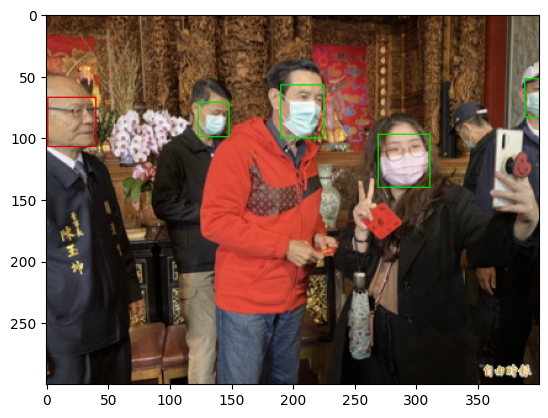

In [22]:
img_path = "/kaggle/input/face-mask-detection/images/maksssksksss457.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

boxes, labels = inference(model, image, eval_transform)

new_img = draw_boxes(image, boxes, labels)
plt.imshow(new_img)